In [1]:
%run "../../shared/utilz_includez.ipynb"

In [2]:
def plot_image( img_array , cmapd='gray', title=None):     
    print( f"image.shape = {img_array.shape}" ) 
    print( f"datatype = {img_array.dtype}")
    print( f"min = {np.min(img_array)} , max = {np.max(img_array)}\n" )
    if cmapd:
        plt.imshow( img_array , cmap=cmapd)
    else:
        plt.imshow( img_array )
    if title:
        plt.title(title)

# Denoising
- Choice between speed and signal-noise. Focus on the important information in the image and not just high res
- Digital filters are a convolution between a kernel and your image. A convolution is a multiplication of arrays/matrices - a smaller one and a bigger one
- A kernel is the smaller matrix with informatio no the desired effect/clean-up to be applied. It can be linear or non-linear 
    - The sum of kernel = 1 b/c not changing the energy of the image
- Non-linear kernels typically preserve edges 

Examples
    - Non-local-means:
    - `scipy.ndimage.gaussian_filter`

In [3]:
from skimage import io, img_as_float, img_as_ubyte
from scipy import ndimage as nd

In [4]:
# imgpath = "https://image.shutterstock.com/image-photo/cross-section-skin-tissue-microscopic-260nw-303503024.jpg"
# imgpath = "https://ak.picdn.net/shutterstock/videos/1012767437/thumb/1.jpg?ip=x480"
imgpath = "https://upload.wikimedia.org/wikipedia/commons/a/a0/SkinTumors-P7110453.JPG"
#imgpath = "https://www.jai.com/uploads/images/_transContentImage765xAuto/Skin-cells-bright-field.jpg"
#imgpath = "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR_X7PDZCN8vF_OWSVJD9WG_rU3WZMkG99nwdotwCM9uD3gp_X4&usqp=CAU"

img = io.imread( imgpath, as_gray=True)
#plot_image( img )
print( img.shape )

(1200, 1600)


In [5]:
## Non-local-means Approach
from skimage.restoration import denoise_nl_means, estimate_sigma

image.shape = (1200, 1600)
datatype = float64
min = 0.02952392156862745 , max = 1.0

image.shape = (1200, 1600)
datatype = float64
min = 0.19288935384488975 , max = 0.9367572873976169

image.shape = (1200, 1600)
datatype = float64
min = 0.31437067412706216 , max = 0.9338650387794044

image.shape = (1200, 1600)
datatype = float64
min = 0.08970274509803922 , max = 0.9994345098039217

image.shape = (1200, 1600)
datatype = float64
min = 0.1727141176470588 , max = 0.9386466666666667

image.shape = (1200, 1600)
datatype = float64
min = 0.02952392156862745 , max = 1.0



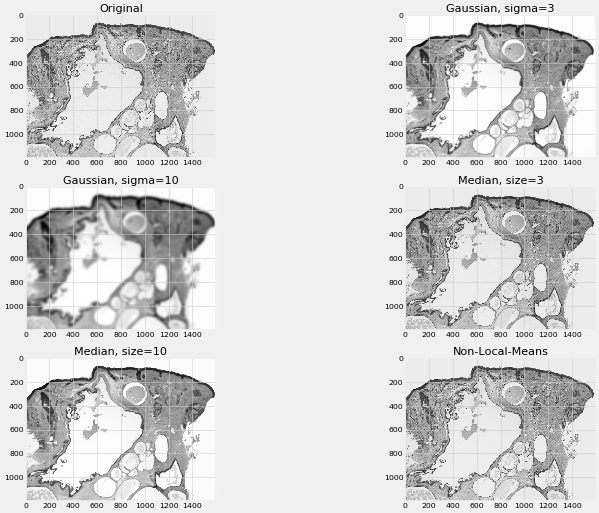

In [6]:
sig = np.mean( estimate_sigma(img, multichannel=True) ) ## fpr Non-local-means method 

plt.subplot(3,2,1)
plot_image( img )
plt.title("Original")

## Apply Gaussian Denoising <<< if you zoom in the gaussian image is clean despite being blurred
plt.subplot(3,2,2)
plot_image(nd.gaussian_filter(img, sigma=3), title="Gaussian, sigma=3");

plt.subplot(3,2,3)
plot_image(nd.gaussian_filter(img, sigma=10), title="Gaussian, sigma=10")

## Median preserves edges
plt.subplot(3,2,4)
plot_image(nd.median_filter(img, size=3), title="Median, size=3"); 

plt.subplot(3,2,5)
plot_image(nd.median_filter(img, size=10), title="Median, size=10"); 

plt.subplot(3,2,6)
plot_image( denoise_nl_means(img, h=1.15*sig, fast_mode=False, patch_size=5, patch_distance=3, multichannel=True), title="Non-Local-Means"); 

plt.savefig( "denoising_various.png"); 

# Histogram Segmentation
- 

In [7]:
dimg = img_as_ubyte( denoise_nl_means(img, h=1.15*sig, fast_mode=False, patch_size=5, patch_distance=3, multichannel=True) )
print( dimg.shape)

(1200, 1600)


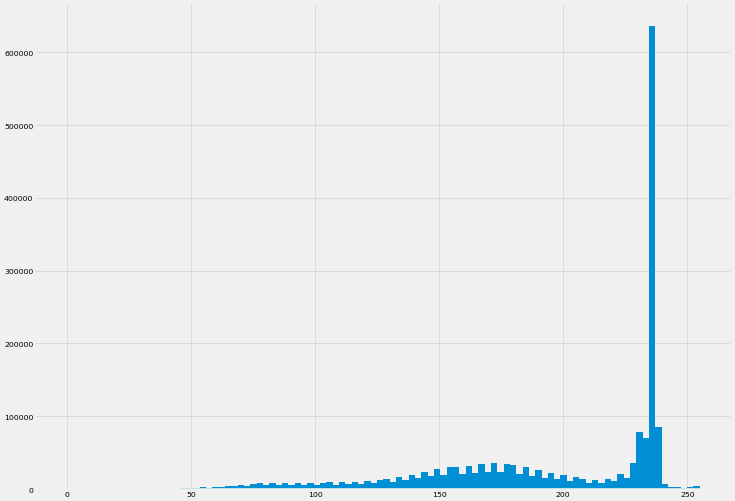

In [8]:
## Plot the histogram
plt.hist( dimg.flat, bins=100, range=(0,255)); 

image.shape = (1200, 1600)
datatype = uint8
min = 8 , max = 255

image.shape = (1200, 1600, 3)
datatype = float64
min = 0.0 , max = 1.0



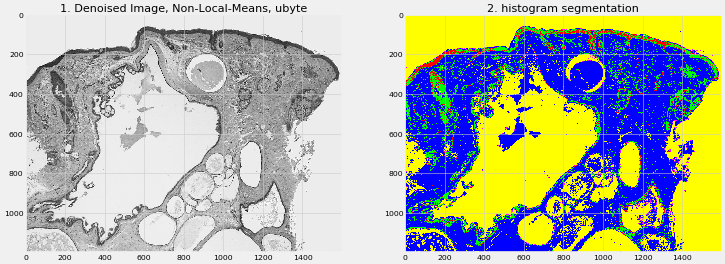

In [9]:
seg1 = dimg <=75
seg2 = (dimg > 75) & (dimg <= 125)
seg3 = (dimg > 125) & (dimg <= 225)
seg4 = (dimg > 225) & (dimg <= 240)
seg5 = dimg > 240

# for z in [seg1, seg2, seg3, seg4, seg5]:
#     print( z.shape )

all_segz = np.zeros( (dimg.shape[0], dimg.shape[1],3) )
# print( all_segz.shape )

all_segz[seg1] = (1,0,0) #R
all_segz[seg2] = (0,1,0) #G
all_segz[seg3] = (0,0,1) #B
all_segz[seg4] = (1,1,0) #Y
all_segz[seg5] = (1,0,1) #P

plt.subplot(1, 2, 1)
plot_image(dimg, title="1. Denoised Image, Non-Local-Means, ubyte");

plt.subplot(1, 2, 2)
plot_image( all_segz, title='2. histogram segmentation'); 

Can clean the image further to remove the spots and have nice solid colours in each segment

image.shape = (1200, 1600, 3)
datatype = float64
min = 0.0 , max = 1.0

image.shape = (1200, 1600, 3)
datatype = float64
min = 0.0 , max = 1.0



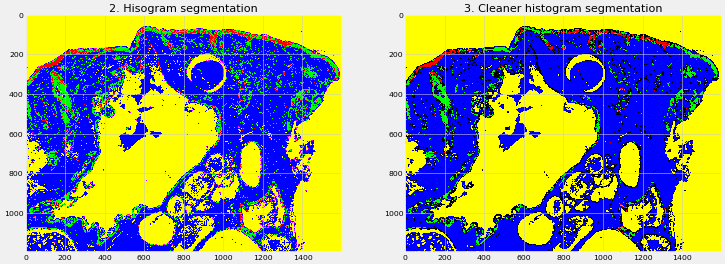

In [10]:
## Let's do binary opening and closing operations, which take care of stray pixels and stray voids respectively

segzz = [seg1, seg2, seg3, seg4, seg5]
segz_c = [ (1,0,0), (0,1,0), (0,0,1), (1,1,0), (1,0,1)]

all_segz_cleaner = np.zeros( (dimg.shape[0], dimg.shape[1],3) )

for seg, cr in zip(segzz, segz_c):
    z = nd.binary_closing(   nd.binary_opening(  seg, np.ones((3,3))) ,   np.ones((3,3)))
    all_segz_cleaner[ z ] = cr
    
plt.subplot(1, 2, 1)
plot_image(all_segz, title="2. Hisogram segmentation");

plt.subplot(1, 2, 2)
plot_image( all_segz_cleaner, title='3. Cleaner histogram segmentation'); 

In [11]:

## Putting all togetehr
dimz = (*dimg.shape,3)
def ready_image( img, segz=segzz,  segz_c=segz_c, dimz=dimz ): 
    
    all_segz_cleaner = np.zeros( dimz )
#     print(f"dimz = {dimz}")

    for seg, cr in zip(segz, segz_c):
#         print( seg.shape )
        k = np.ones( (3,3)) #if len(seg.shape) == 2 else np.ones((3,3,3))
#         print( f"structure: {k.shape}" )
        z = nd.binary_closing(   nd.binary_opening(  seg, k) ,  k)
        all_segz_cleaner[ z ] = cr

    plt.subplot(1, 2, 1)
    plot_image(img, title="1. Original Image");

    plt.subplot(1, 2, 2)
    plot_image( all_segz_cleaner, title='3. Histogram Segmentation'); 

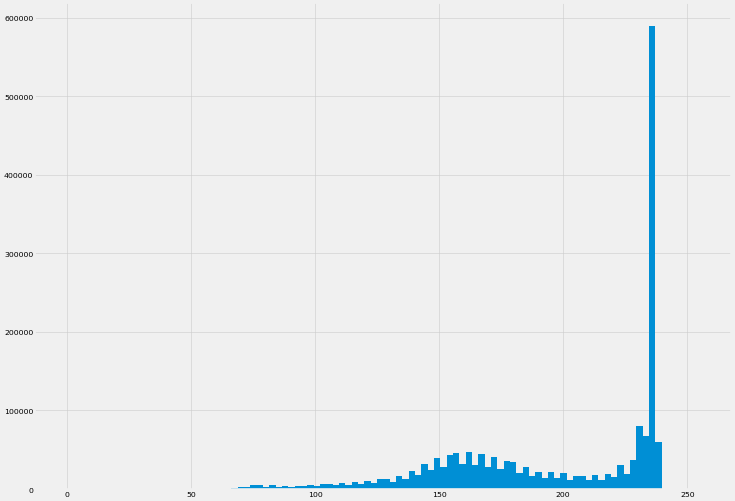

In [12]:
## 2. Gaussian sigma=3
dimg = img_as_ubyte( nd.gaussian_filter(img, sigma=3)  )
plt.hist( dimg.flat, bins=100, range=(0,255)); 

image.shape = (1200, 1600)
datatype = float64
min = 0.02952392156862745 , max = 1.0

image.shape = (1200, 1600, 3)
datatype = float64
min = 0.0 , max = 1.0



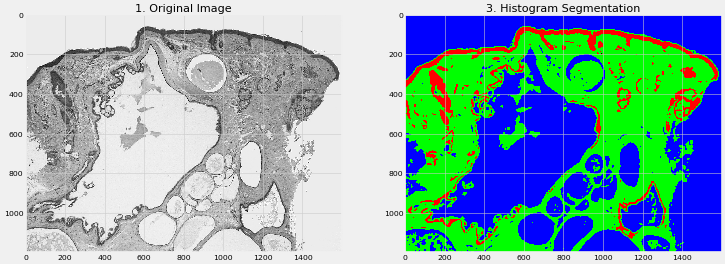

In [13]:
seg1 = dimg <=125
seg2 = (dimg > 125) & (dimg <= 210)
seg3 = dimg > 210
ready_image(img, [seg1, seg2, seg3], segz_c[:3])

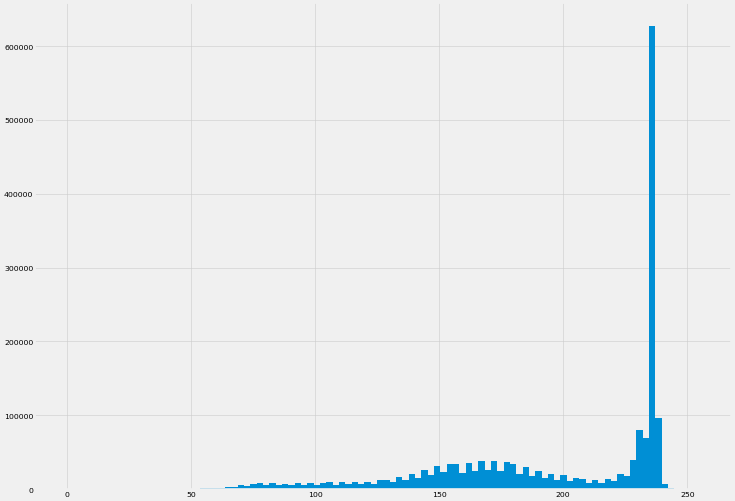

In [14]:
## 2. Median size=3
dimg = img_as_ubyte( nd.median_filter(img, size=3)  )
plt.hist( dimg.flat, bins=100, range=(0,255)); 

image.shape = (1200, 1600)
datatype = float64
min = 0.02952392156862745 , max = 1.0

image.shape = (1200, 1600, 3)
datatype = float64
min = 0.0 , max = 1.0



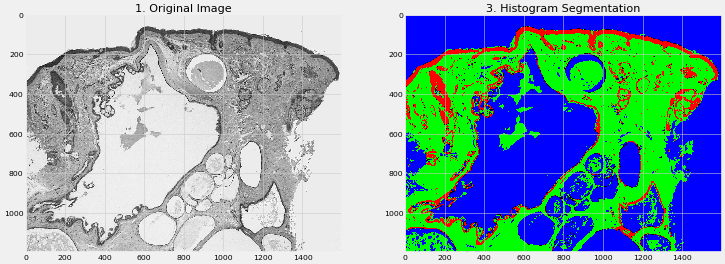

In [15]:
seg1 = dimg <= 125
seg2 = (dimg > 125) & (dimg <= 220)
seg3 = dimg > 220
ready_image(img, [seg1, seg2, seg3], segz_c[:3])

(280, 365)
(280, 365)


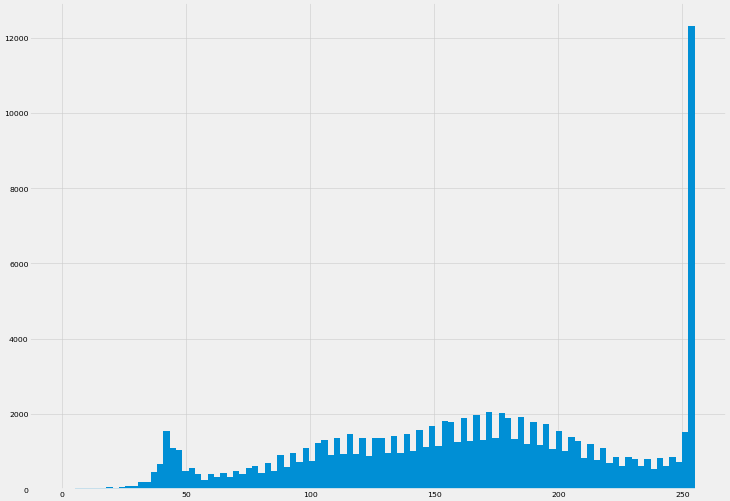

In [16]:
### ======= yaimage
imgpath = "https://image.shutterstock.com/image-photo/cross-section-skin-tissue-microscopic-260nw-303503024.jpg"
img = img_as_float( io.imread( imgpath , as_gray=True)  )

#plot_image( img)
print( img.shape )

sig = np.mean( estimate_sigma(img, multichannel=True) ) ## fpr Non-local-means method 
dimg2 = img_as_ubyte( denoise_nl_means(img, h=1.15*sig, fast_mode=False, patch_size=5, patch_distance=3, multichannel=True) )
 

print( dimg2.shape);

plt.hist( dimg2.flat, bins=100, range=(0,255));


image.shape = (280, 365)
datatype = float64
min = 0.008080392156862744 , max = 1.0

image.shape = (280, 365, 3)
datatype = float64
min = 0.0 , max = 1.0



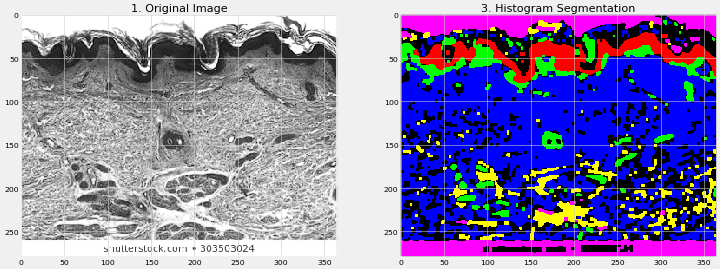

In [17]:
seg1 = dimg2 <=50
seg2 = (dimg2 > 50) & (dimg2 <= 100)
seg3 = (dimg2 > 100) & (dimg2 <= 200)
seg4 = (dimg2 > 200) & (dimg2 <= 250)
seg5 = dimg2 > 250

dimz = (dimg2.shape[0], dimg2.shape[1], 3) 

# print( dimz )
# for z in [seg1, seg2, seg3, seg4, seg5]:
#     print(z.shape)

ready_image(img, [seg1, seg2, seg3, seg4, seg5], segz_c, dimz=dimz)

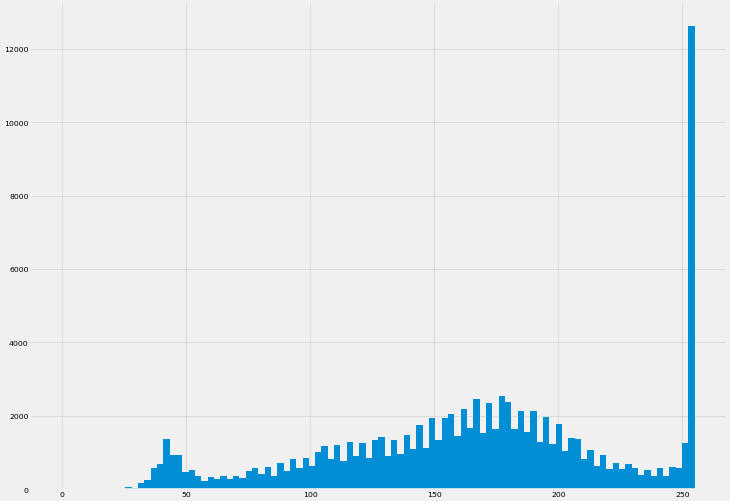

In [18]:
## 2. Median size=3
dimg = img_as_ubyte( nd.median_filter(img, size=3) )

# print( dimg.shape )
plt.hist( dimg.flat, bins=100, range=(0,255)); 

image.shape = (280, 365)
datatype = float64
min = 0.008080392156862744 , max = 1.0

image.shape = (280, 365, 3)
datatype = float64
min = 0.0 , max = 1.0



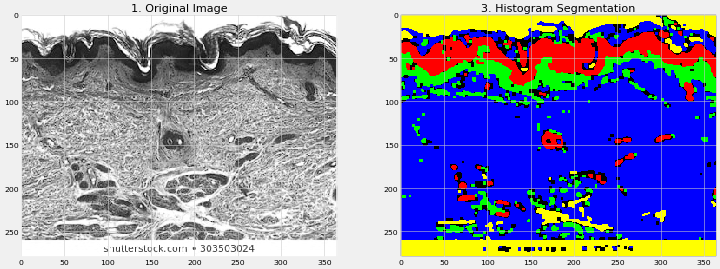

In [19]:
seg1 = dimg <= 85
seg2 = (dimg > 85) & (dimg <= 125)
seg3 = (dimg > 125) & (dimg <= 240)
seg4 = dimg > 240

dimz = (dimg.shape[0], dimg.shape[1], 3) 

ready_image(img, [seg1, seg2, seg3, seg4], segz_c[:4] , dimz=dimz)

>>> Original as grayscale:  (591, 800)
>>> Denoised NLM:  (591, 800)


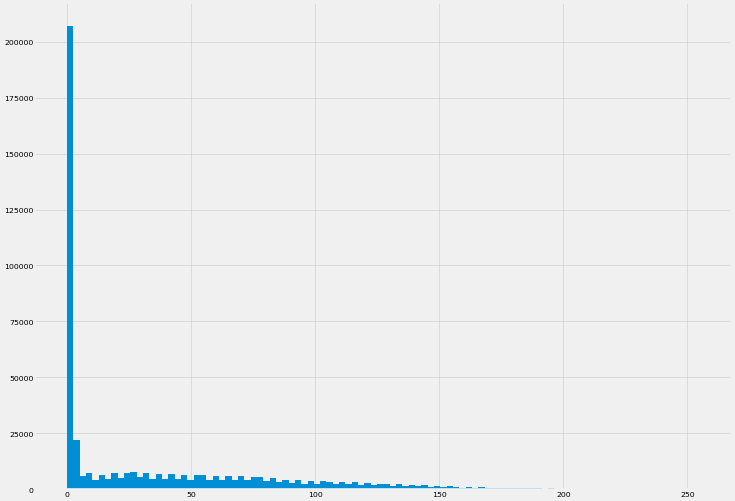

In [20]:
##### ======= YAImage
imgpath = "https://thumbs.dreamstime.com/b/fluorescence-microscope-image-human-cells-undergoing-mitosis-fluorescence-microscope-image-bovine-pulmonary-artery-100397498.jpg"
img = io.imread(imgpath, as_gray=True)

# plot_image( img)
print( ">>> Original as grayscale: ", img.shape )

sig = np.mean( estimate_sigma(img, multichannel=True) ) ## fpr Non-local-means method 
dimg = img_as_ubyte( denoise_nl_means(img, h=1.15*sig, fast_mode=False, patch_size=5, patch_distance=3, multichannel=True) )
 

print( ">>> Denoised NLM: ", dimg.shape);

plt.hist( dimg.flat, bins=100, range=(0,255));


image.shape = (591, 800)
datatype = float64
min = 0.0 , max = 0.9501823529411764

image.shape = (591, 800, 3)
datatype = float64
min = 0.0 , max = 1.0



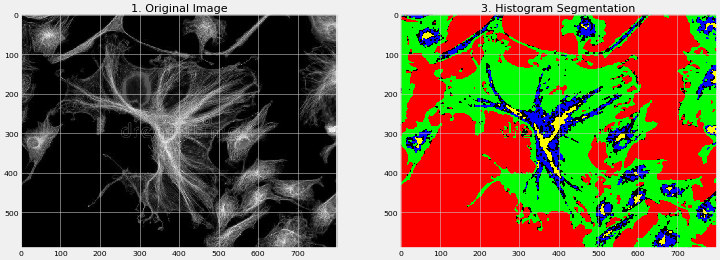

In [21]:
seg1 = dimg <= 10
seg2 = (dimg > 10) & (dimg <= 100)
seg3 = (dimg > 100) & (dimg <= 150)
seg4 = dimg > 150

dimz = (dimg.shape[0], dimg.shape[1], 3) 

ready_image(img, [seg1, seg2, seg3, seg4], segz_c[:4] , dimz=dimz)

>>> Original as grayscale:  (990, 990)
>>> Denoised NLM:  (990, 990)


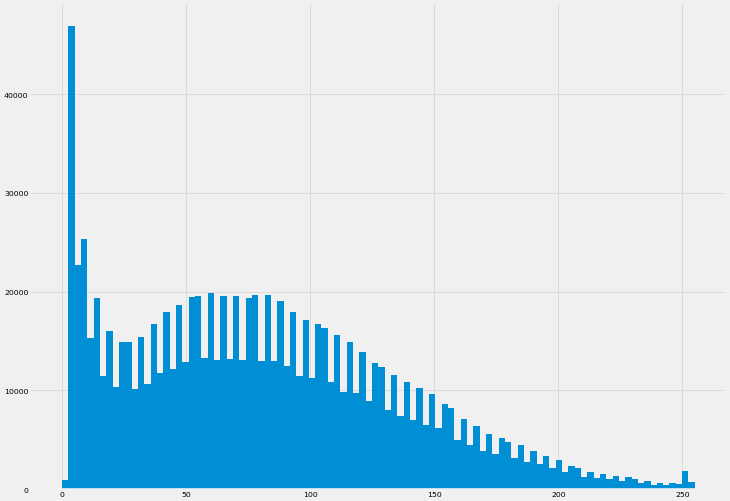

In [22]:
##### ======= YAImage
imgpath = "https://i.pinimg.com/originals/23/b1/da/23b1da664ec94a9f7ab0854cd5d5adb1.jpg"
img = io.imread(imgpath, as_gray=True)

# plot_image( img)
print( ">>> Original as grayscale: ", img.shape )

sig = np.mean( estimate_sigma(img, multichannel=True) ) ## fpr Non-local-means method 
dimg = img_as_ubyte( denoise_nl_means(img, h=1.15*sig, fast_mode=False, patch_size=5, patch_distance=3, multichannel=True) )
 

print( ">>> Denoised NLM: ", dimg.shape);

plt.hist( dimg.flat, bins=100, range=(0,255));


image.shape = (990, 990)
datatype = float64
min = 0.0 , max = 1.0

image.shape = (990, 990, 3)
datatype = float64
min = 0.0 , max = 1.0



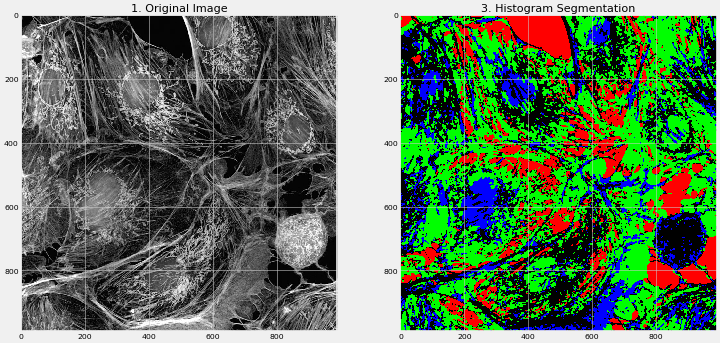

In [23]:
seg1 = dimg <= 25
seg2 = (dimg > 25) & (dimg <= 100)
seg3 = (dimg > 100) & (dimg <= 150)
seg4 = (dimg > 150) & (dimg <= 225)
seg5 = dimg > 225

dimz = (dimg.shape[0], dimg.shape[1], 3) 

ready_image(img, [seg1, seg2, seg3], segz_c[:5] , dimz=dimz)

In [24]:
from skimage.filters import threshold_minimum, threshold_yen, threshold_otsu, threshold_mean

from skimage.filters.rank import entropy
from skimage.morphology import disk 

## try different thresholds
from skimage.filters import try_all_threshold


In [ ]:

d = 10
entrop_img = entropy( img, disk( d ))
    
fig, ax = try_all_threshold( entrop_img , figsize=(20,30) , verbose=False) 

In [ ]:
   
plt.subplot(1, 3, 1)
plot_image( entrop_img <= threshold_otsu( entrop_img ) )
plt.title(f'OTSU threshold segmentation - disk {d}'); 

plt.subplot(1, 3, 2)
plot_image( entrop_img <= threshold_mean( entrop_img ) )
plt.title(f'Mean threshold segmentation - disk {d}'); 

plt.subplot(1, 3, 3)
plot_image( entrop_img <= threshold_yen( entrop_img ) )
plt.title(f'Yen threshold segmentation - disk {d}' ); 

In [ ]:
eimg = img_as_float( entrop_img <= threshold_mean( entrop_img ) )
sig = np.mean( estimate_sigma( eimg, multichannel=True) ) ## fpr Non-local-means method 
dimg = img_as_ubyte( denoise_nl_means( eimg, h=1.15*sig, fast_mode=False, patch_size=5, patch_distance=3, multichannel=True) )
 
print( ">>> Denoised NLM: ", dimg.shape);
plt.hist( dimg.flat, bins=100, range=(0,255));


In [ ]:
seg1 = dimg <= 25
seg2 = (dimg > 25) & (dimg <= 100)
seg3 = (dimg > 100) & (dimg <= 200)
seg4 = (dimg > 225) & (dimg <= 225)
seg5 = dimg > 225

dimz = (dimg.shape[0], dimg.shape[1], 3) 

ready_image( img_as_ubyte(img), [seg1, seg2, seg3], segz_c[:5] , dimz=dimz)

In [ ]:
plt.imshow( img_as_ubyte(img), cmap="copper" )